# Flow past a cylinder

In [2]:
using ViscousFlow

In [ ]:
using Plots
pyplot()
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [4]:
Re = 200; # Reynolds number
U = 1.0; # Free stream velocity
U∞ = (U,0.0);

Set the grid dimensions, grid spacing, and time step size

In [5]:
xlim = (-1.0,4.0)
ylim = (-2.0,2.0);
Δx, Δt = setstepsizes(Re,gridRe=4)

(0.02, 0.01)

Set up points on the body.

In [6]:
body = Circle(0.5,Δx)

Circular body with 157 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Transform the body to lie at a specific position. Here, we just put it at the origin.

In [7]:
cent = (0.0,0.0)
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Circular body with 157 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set up the domain and plot the body inside it.

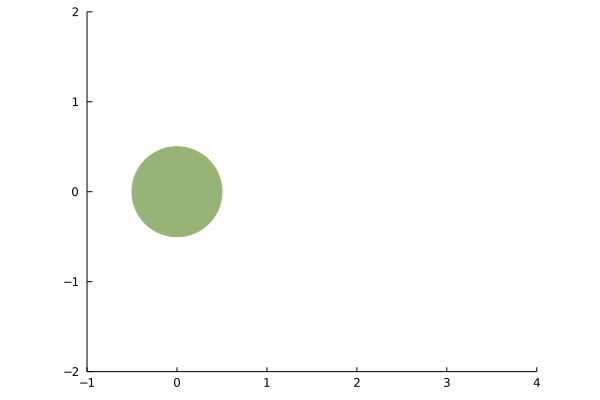

In [8]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [9]:
X = VectorData(collect(body));

### Now set up the system

Set up the state vector and constraint force vector for a static body

In [10]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true)

Navier-Stokes system on a grid of size 252 x 208

In [11]:
w₀ = Nodes(Dual,size(sys));
f = VectorData(X);

In [12]:
x0 = (1.5,0.0)
A = 10.0
t0 = 4.0
sigt = 1.0
wf = PointForce(w₀,x0,A,t0,sigt,sys)

Transient point force applied on the Nodes{Dual,252,208,Float64,Array{Float64,2}} field.
   strength = 10.0
   location = [1.5, 0.0]
   central time = 4.0
   half-interval = 1.0


Set up the integrator here

In [13]:
plan_intfact(t,u) = CartesianGrids.plan_intfact(t,u,sys)
plan_constraints(u,t) = ConstrainedSystems.plan_constraints(u,t,sys)
r₁(u,t) = ConstrainedSystems.r₁(u,t,sys) + wf(t)
r₂(u,t) = ConstrainedSystems.r₂(u,t,sys)

@time solver = IFHERK(w₀,f,sys.Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=ConstrainedSystems.RK31)

  8.234397 seconds (19.88 M allocations: 4.054 GiB, 5.11% gc time)


Order-3 IF-HERK integrator with
   State of type Nodes{Dual,252,208,Float64,Array{Float64,2}}
   Force of type VectorData{157,Float64,Array{Float64,1}}
   Time step size 0.01


In [14]:
typeof(w₀)

Nodes{Dual,252,208,Float64,Array{Float64,2}}

Initialize the state vector and the history vectors

In [15]:
t = 0.0
u = zero(w₀)

# Rate at which to store field data
tsample = 0.2

# Field data storage plan
S = StorePlan(tsample,"state"=>u,"time"=>t)
data_history = initialize_storage(S)

# Force data storage plan, stored every time step
F = StorePlan(timestep(sys),"fx"=>sum(f.u),"fy"=>sum(f.v),"time"=>t)
force_history = initialize_storage(F)
nothing

### Advance the system!

Set the time range to integrate over.

In [16]:
tf = 10.0;
T = Δt:Δt:tf;

In [17]:
@time for ti in T
    global t, u, f = solver(t,u)
    
    fds = force(f,sys) 
    
    store_data!(data_history,t,S,"state" => u, "time" => t)
    store_data!(force_history,t,F,"fx" => sum(fds.u),"fy" => sum(fds.v),"time" => t)
    
end
println("solution completed through time t = ",t)

 45.990427 seconds (17.37 M allocations: 39.089 GiB, 3.48% gc time)
solution completed through time t = 9.999999999999831


#### Plotting

Basic plot

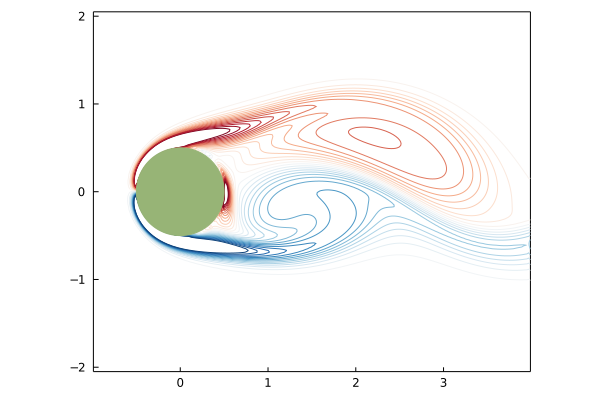

In [18]:
plot(vorticity(data_history["state"][end],sys),sys,levels=range(-5,stop=5,length=30), color = :RdBu,clims=(-5,5),trim=1)
plot!(body)

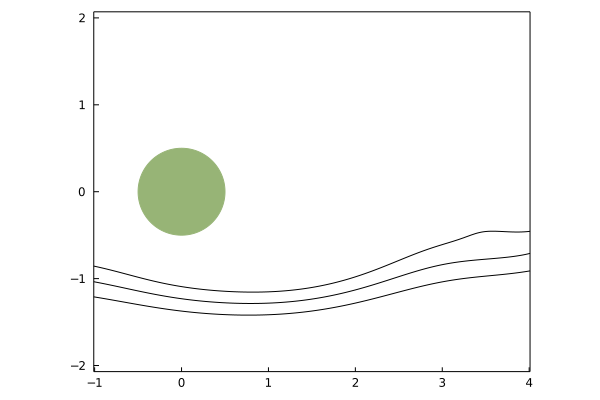

In [19]:
plot(streamfunction(data_history["state"][end],sys),sys,levels=range(-2,3,length=31), color = :black,clim=(-0.25,0.25))
plot!(body)

Make a movie

┌ Info: Saved animation to 
│   fn = /home/sinan/Documents/turbulence/ViscousFlow.jl/examples/cylinderRe200-2.gif
└ @ Plots /home/sinan/.julia/packages/Plots/vsE7b/src/animation.jl:104


Plots.AnimatedGif("/home/sinan/Documents/turbulence/ViscousFlow.jl/examples/cylinderRe200-2.gif")
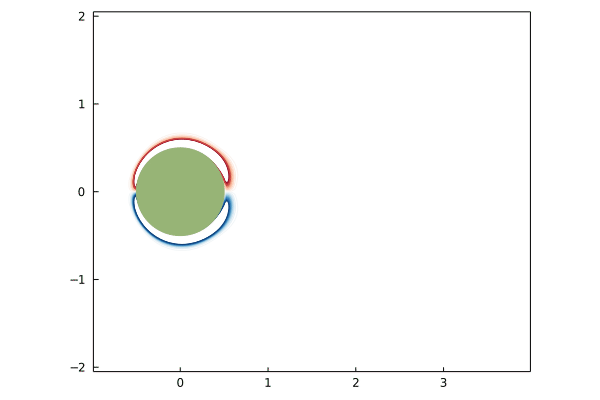

In [20]:
anim = @animate for i = 1:length(data_history["state"])
    plot(vorticity(data_history["state"][i],sys),sys,levels=range(-5,stop=5,length=30), color = :RdBu,clims=(-5,5),trim=1)
    plot!(body)
end
gif(anim,"cylinderRe200-2.gif")

Plot force histories

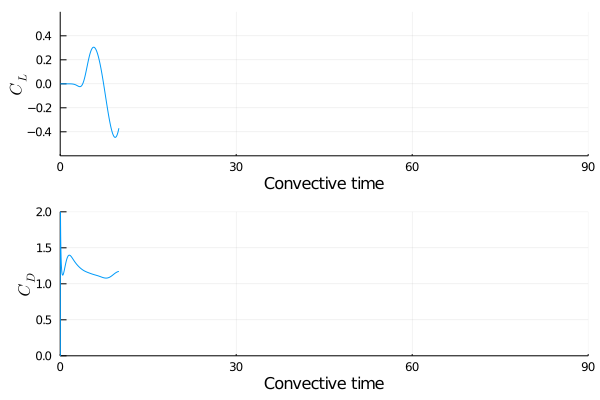

In [21]:
plt = plot(layout = (2,1), size = (600, 400))
plot!(plt[1],force_history["time"],2*force_history["fy"],xlim=(0,90),ylim=(-0.6,0.6),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot!(plt[2],force_history["time"],2*force_history["fx"],xlim=(0,90),ylim=(0,2),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
plt

In [22]:
using Statistics

In [23]:
force_history["time"][end]

9.999999999999831

In [24]:
Statistics.mean(2*fx[2000:end])

LoadError: UndefVarError: fx not defined

In [25]:
using FFTW

LoadError: ArgumentError: Package FFTW not found in current path:
- Run `import Pkg; Pkg.add("FFTW")` to install the FFTW package.


In [26]:
nt = length(thist[2000:end])
nfreq = (nt-1)÷2+1
fsamp = 1/Δt
freq = 0.5*fsamp*range(0,stop=1.0,length=nfreq)
#fhat = fft(fy[2000:nt-1])/(nt-1-2000+1)
fhat = fft(fy[2000:end])/(nt-1)
plot(freq,4*abs.(fhat[1:nfreq]),xlim=(0,1),grid=:true)

LoadError: UndefVarError: thist not defined

In [27]:
freq[findmax(abs.(fhat[1:nfreq]))[2]]

LoadError: UndefVarError: nfreq not defined